# Reading ImageNet from tfrecord files using NVidia DALI

Here we will use the [NVidia DALI](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html)'s [tfrecord](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/operations/nvidia.dali.fn.readers.tfrecord.html#nvidia-dali-fn-readers-tfrecord) reader to read the ImageNet dataset stored in tfrecord files.

Besides the tfrecord files, Nvidia DALI needs information of the position of the records on the file. That's created by the Nvidia DALI's utility script [tfrecord2idx](https://github.com/NVIDIA/DALI/blob/main/tools/tfrecord2idx).

In [1]:
import glob
import matplotlib.pyplot as plt
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
from nvidia.dali.pipeline import Pipeline
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy

/apps/daint/UES/6.0.UP04/sandboxes/sarafael/hpcpython2022/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/'

tfrec_files = sorted(glob.glob(f'{data_dir}/train/*'))
index_files = sorted(glob.glob(f'{data_dir}/idx_files/train/*'))

In [3]:
tfrec.FixedLenFeature?

Docstring: FixedLenFeature(arg0: List[int], arg1: int, arg2: object) -> nvidia.dali.backend_impl.tfrecord.Feature
Type:      builtin_function_or_method


In [4]:
pipe = Pipeline(batch_size=64,
                num_threads=12,
                device_id=0)

with pipe:
    example = fn.readers.tfrecord(
        path=tfrec_files,
        index_path=index_files,
        features={
            'image/encoded': tfrec.FixedLenFeature((), tfrec.string, ''),
            'image/class/label': tfrec.FixedLenFeature((), tfrec.int64, -1),
        }
    )
    label = example['image/class/label'] - 1
    image = fn.decoders.image(example['image/encoded'], device='mixed', output_type=types.RGB)
    image = fn.resize(image, device='gpu', size=(224, 224))
    pipe.set_outputs(image, label)

In [5]:
pipe.build()

In [6]:
loader = DALIClassificationIterator(
    pipe,
    last_batch_padded=False,
    auto_reset=True,
    last_batch_policy=LastBatchPolicy.DROP,
)

In [7]:
for i, samples in enumerate(loader):
    imgs, labels = (samples[0]['data'], samples[0]['label'])
    if i > 10:
        break

In [8]:
imgs.shape

torch.Size([64, 224, 224, 3])

In [9]:
labels.shape

torch.Size([64])

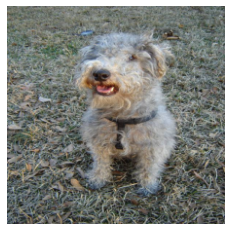

In [10]:
plt.imshow(imgs.cpu()[22])
plt.axis('off')
plt.show()